<a href="https://colab.research.google.com/github/jyotidabass/Email-Engagement/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Email Alchemy: Decoding Engagement Metrics for Marketing Magic**

Step into the wizardry of email marketing as we unveil the secrets behind open rates, click-through rates, and conversion rates. In this EDA journey, we'll transform data into insights, forging the path to marketing mastery. Let's get started!

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#Load the pickle file

with open('/content/email_campaigns.pkl', 'rb') as file:
  data = pickle.load(file)

In [3]:
data[0]

{'example1': [{'subject': '🚀 Propel Your Marketing ROI with Advanced Analytics!',
   'body': "Hey [Recipient's Name],\n\nReady to see your marketing performance soar? With our cutting-edge Marketing Analytics services, your business can harness the power of data to drive decision-making and skyrocket ROI!\n\nQuick question - are you leveraging your data to its full potential? Let's talk strategy! 👉 [meeting link]\n\nBest,\n[Your Name]",
   'opened': False,
   'meeting link clicked': False,
   'responded': False},
  {'subject': 'Data is Your Superpower 📊 Unlock Insights with Us',
   'body': "Hi [Recipient's Name],\n\nI'm reaching out again because I believe our last message might've slipped through the cracks. With your goals in mind, our marketing analytics can translate your data into actionable strategies that can redefine your marketing's success.\n\nCan we help you harness this superpower? Book a time on my calendar: [meeting link]. Looking forward to connecting!\n\nCheers,\n[Your 

## **Data Cleaning**

In [4]:
# Extract email data from the 'example1' key in each record

email_data = []
for record in data:
    example1_list = record.get('example1', [])
    if example1_list:
        email_data.extend(example1_list)

In [5]:
#Converting the data into dataframe for our convenience
df = pd.DataFrame(email_data)

In [6]:
df.head(3)

,subject,body,opened,meeting link clicked,responded,meeting_link_clicked
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,False,NaN
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,False,NaN
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,False,NaN


In [7]:
#save to csv format for further uses
df.to_csv('email_data.csv')

### Check for potential issues

As we can observe that there are redundant columns,so let's check for them and aim in keeping the most relevant column

In [8]:
def check_nulls(df, column_name):
    null_count = df[column_name].isnull().sum()
    print(f"Nulls in '{column_name}': {null_count}")
    return null_count

# Check for nulls in columns 'meeting link clicked' and 'meeting_link_clicked'
nulls_meeting_link_clicked = check_nulls(df, 'meeting link clicked')
nulls_meeting_link_clicked_alternate = check_nulls(df, 'meeting_link_clicked')

Nulls in 'meeting link clicked': 6
Nulls in 'meeting_link_clicked': 75


There are missing values in both columns, hence let's fill one column with values from the other column that will solve the issue above


In [9]:
df['meeting link clicked'].fillna(df['meeting_link_clicked'], inplace=True)

# Drop the redundant column
df.drop(columns=['meeting_link_clicked'], inplace=True)

In [10]:
# an overall check for missing values
df.isna().sum()

subject                 0
body                    0
opened                  0
meeting link clicked    0
responded               0
dtype: int64

We efficiently tackled two challenges with a single solution:

**Redundant Columns:** Identified and resolved the redundancy issue by recognizing similar columns with different names, streamlining our dataset for clarity and consistency.

**Handling Missing Values**: The systematic null check provided insights into the completeness of our data, aiding in the understanding and mitigation of missing values.

In [11]:
df.head(3)

,subject,body,opened,meeting link clicked,responded
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,False
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,False
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,False


In [12]:
# Display basic information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject               81 non-null     object
 1   body                  81 non-null     object
 2   opened                81 non-null     object
 3   meeting link clicked  81 non-null     object
 4   responded             81 non-null     object
dtypes: object(5)
memory usage: 3.3+ KB


**Size:** The dataset contains 81 entries, making it moderately sized.

**Columns:**

subject and body contain text data.
opened, meeting link clicked, and responded are numerical indicators.

**Data Types:** Appropriate data types are assigned.

Memory Usage: The dataset is lightweight, consuming approximately 3.3 KB.

In [13]:
# Descriptive statistics
stats_df = df.describe(include='all')
stats_df

,subject,body,opened,meeting link clicked,responded
count,81,81,81,81,81
unique,81,81,2,2,2
top,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",True,False,False
freq,1,1,60,57,77


**Key Insights:**

1.   Email opening is relatively common, with a substantial proportion opened.
2.   Click-through rates and response rates are lower, suggesting opportunities for improvement in engagement strategies.

These statistics provide a snapshot of engagement metrics, guiding our focus on enhancing click-through and response rates for more effective email campaigns.

In [14]:
# for further analysis, let's convert  'opened', 'meeting link clicked', and
# 'responded' to numeric values

df[['opened', 'meeting link clicked', 'responded']] = df[['opened', 'meeting link clicked', 'responded']].astype(int)

## **Visual Exploration**

In [15]:
# Analysis of relationships and engagement dynamics

def plot_distribution_analysis(df):
    """
    Plot distribution analysis for 'opened', 'meeting link clicked', and 'responded'.
    """
    fig_dist = px.histogram(df, x=['opened', 'meeting link clicked', 'responded'],
                            color='opened', barmode='overlay', title='Distribution Analysis')
    return fig_dist

def plot_scatter_matrix(df):
    """
    Plot a scatter matrix to analyze relationships among engagement metrics.
    """
    fig = px.scatter_matrix(df, dimensions=['opened', 'meeting link clicked', 'responded'],
                            color='opened', title='Relationship Analysis')
    return fig

def plot_interactive_sunburst(df):
    """
    Plot an interactive sunburst chart to visualize engagement pathways.
    """
    fig = px.sunburst(df, path=['opened', 'meeting link clicked', 'responded'], title='Interactive Sunburst Chart')
    return fig

In [16]:
# Initiating visual exploration

fig_dist = plot_distribution_analysis(df)
fig_rel = plot_scatter_matrix(df)
fig_interactive = plot_interactive_sunburst(df)

# Show plots
fig_dist.show()
fig_rel.show()
fig_interactive.show()

### **Distribution Chart Key Insights:**

**Opened Emails:**

A considerable number of emails were opened, indicating a decent engagement level.
A subset of opened emails also had the meeting link clicked.

**Meeting Link Clicked:**

The majority of emails did not have the meeting link clicked.
A notable portion of opened emails resulted in link clicks.

**Responded:**

Responses were relatively infrequent, suggesting an opportunity for improvement in engagement strategies.

### **Scatter Matrix Insights:**

**Opened Emails vs. Meeting Link Clicked:**

A positive correlation is evident between 'opened' and 'meeting link clicked.'
**Corroboration from Distribution Analysis:** A subset of opened emails resulted in link clicks.

**Opened Emails vs. Responded:**

Limited correlation is observed between 'opened' and 'responded.'
Corroboration from Distribution Analysis: Responses were infrequent across both opened and not opened emails.

**Meeting Link Clicked vs. Responded:**

A positive correlation exists, suggesting that emails with a clicked link are more likely to receive a response.
**Corroboration from Distribution Analysis:** While the majority of emails did not receive a response, a notable portion of opened and link-clicked emails did receive responses.


### **Sunburst Chart Key Insights:**
The sunburst chart provides an interactive visualization of engagement pathways, shedding light on the hierarchical relationships among 'opened,' 'meeting link clicked,' and 'responded.'

**Engagement Pathways:**

**Level 1 (Outer Ring):**

 **'Opened':**
Majority of emails fall into this category, representing both opened and not opened emails.

**Level 2 (Middle Ring):**

 **'Meeting Link Clicked':**
Distinguishes between emails with a clicked link and those without.

**Level 3 (Inner Ring):**

 **'Responded':**
Highlights the subset of emails that received a response.

### **Insights:**

**Sequential Engagement Flow:**

Most emails follow the path of being opened, with a subset progressing to clicking the meeting link.
A smaller subset of these engaged emails receives a response.

**Significant 'Opened' Volume:**

The outer ring, representing 'opened,' is substantial, indicating a high volume of email openings.

**Challenges in 'Responded' Pathway:**

Despite substantial 'opened' volume, the innermost ring ('responded') is smaller, indicating challenges in converting engagements to responses.

## **Text Analysis**

In [17]:
# Initiating WordCloud Analysis to Explore Email Subject Keywords

def generate_wordcloud(text_data, title):
    """
    Generate a WordCloud based on the provided text data.
    """
    wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=400).generate(' '.join(text_data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

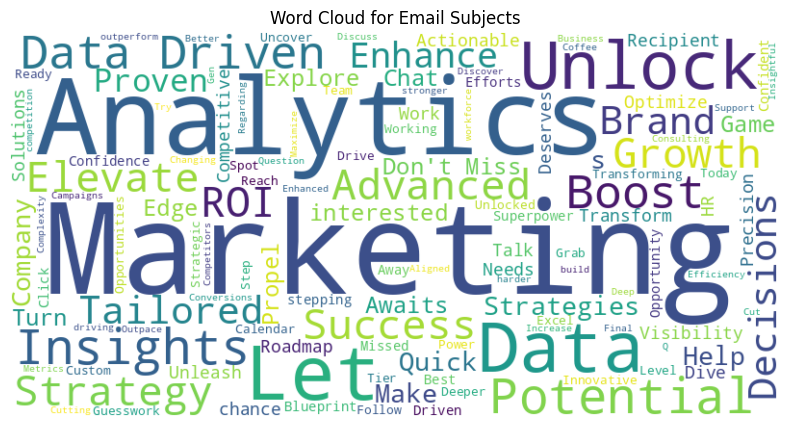

In [18]:
# Generating WordCloud for 'subject'
generate_wordcloud(df['subject'], 'Word Cloud for Email Subjects')

### **Key Observations:**

**Prominent Keywords:**



1.   "Marketing," "Analytics," "Data": Indicates a focus on marketing analytics and data-driven strategies.
2.   "Insights","Boost": Indicates a focus on excitement drive for the recipents.

**Campaign Themes:**

**Marketing Analytics Focus:** The recurrence of "Marketing" and "Analytics" suggests a strong emphasis on data-driven marketing strategies.

**Engagement Prompts:** Frequent use of words like "Insights" and "Boost" indicates a call to action for recipients to engage.

**Potential Improvements:**

**Diversify Content:** While current themes are clear, exploring variations and diversifying content could enhance engagement.

**Emphasize Value Proposition:** Strengthening the value proposition in email subjects may improve open and click-through rates.

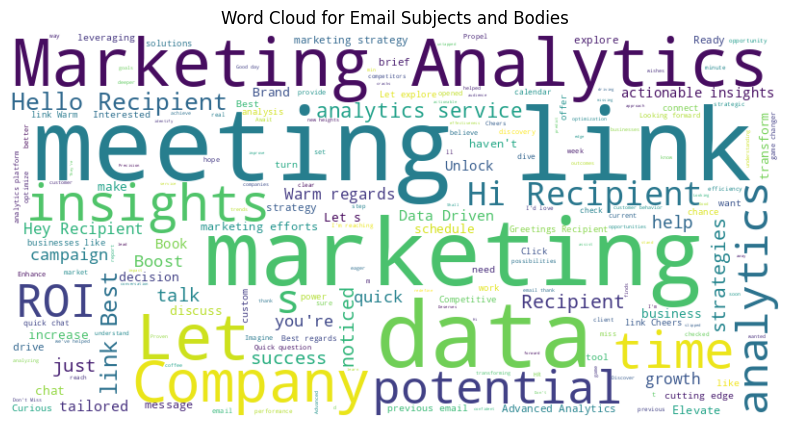

In [19]:
# Generating WordCloud for both 'subject' and 'body'
combined_text = df['subject'] + ' ' + df['body']
generate_wordcloud(combined_text, 'Word Cloud for Email Subjects and Bodies')

### **Key Observations:**

#### **"Meeting" and "Link":**

**Implication:** Emphasis on prompting recipients to engage with provided meeting links.

**Action:** Optimize messaging around meetings and link utilization for enhanced engagement.

#### **"Company" and "Marketing":**

**Implication:** Company-centric and marketing-focused messaging is evident.

**Action:** Refine content strategies to balance company information with compelling marketing narratives.

#### **"Data" and "Analytics":**

**Implication:** Strong emphasis on data-driven and analytics-centric approaches.

**Action:** Leverage these themes in crafting content to appeal to recipients interested in data insights.

#### **"Time" and "Insights":**

**Implication:** Time-related and insights-driven content is present.

**Action:** Further explore opportunities to leverage time-sensitive messaging and emphasize insights value.

### **Email Interaction Analysis with Length Metrics**

In [20]:
# Analyzing Email Interaction with Added Length Metrics for 'subject' and 'body'

def add_length_columns(df):
    """
    Add new columns for the length of 'subject' and 'body'.
    """
    df['subject_len'] = df['subject'].apply(len)
    df['body_len'] = df['body'].apply(len)
    return df

def plot_interaction_analysis(df):
    """
    Generate a scatter plot for email interaction analysis.
    """
    fig = px.scatter(df, x='opened', y='meeting link clicked', color='responded', size='subject_len',
                     hover_data=['subject'], title='Email Interaction Analysis')
    fig.update_layout(showlegend=True)
    fig.show()

In [21]:
# Adding length columns
df = add_length_columns(df)

# Generating scatter plot for email interaction analysis
plot_interaction_analysis(df)

### **Length Metrics Addition:**

**Subject Length:**

**Insight:** Subjects vary in length, contributing to visual diversity.

**Body Length:**

**Insight:** Diverse body lengths indicate varying content depth and complexity.

### **Scatter Plot Analysis:**

**X-axis ('opened') vs. Y-axis ('meeting link clicked'):**

**Insight:** Positive correlation, indicating opened emails are more likely to have the meeting link clicked.

**Color ('responded'):**

**Insight:** Differentiating responses with color adds depth to the analysis.

**Size Metric ('subject_len'):**

**Insight:** Larger bubbles signify longer subjects, allowing for quick identification of email length impact.

## **Conversion Funnel Analysis**

In [22]:
#Conversion Funnel Visualization: Analyzing the progression from email opening to meeting link clicking and response

def create_conversion_funnel(df):
    """
    Create a conversion funnel DataFrame.
    """
    conversion_funnel_data = df.groupby(['opened', 'meeting link clicked', 'responded']).size().reset_index(name='count')
    return conversion_funnel_data

def plot_conversion_funnel(conversion_funnel_data):
    """
    Generate a bar plot for conversion funnel visualization.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x='opened', y='count', hue='meeting link clicked', data=conversion_funnel_data)
    plt.title('Conversion Funnel Visualization')
    plt.xlabel('Opened → Meeting Link Clicked → Responded')
    plt.ylabel('Count')
    plt.show()

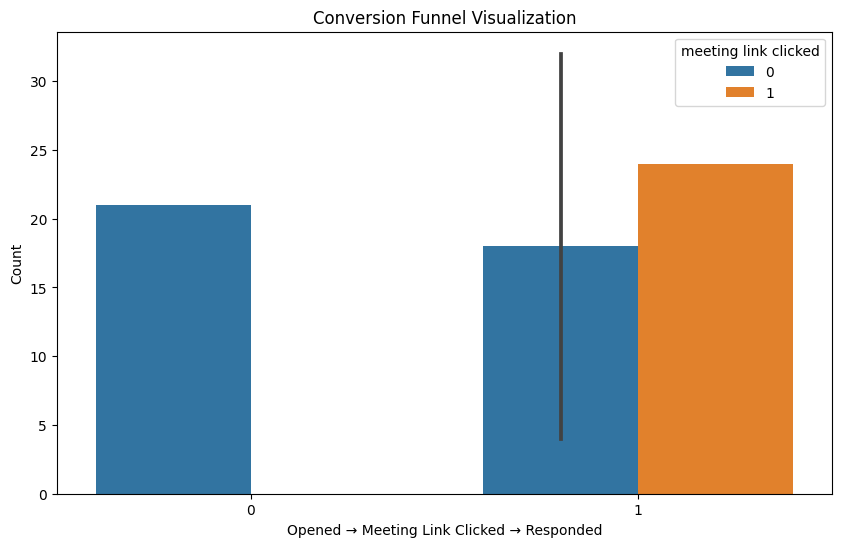

In [23]:
# Creating conversion funnel data
conversion_funnel_data = create_conversion_funnel(df)

# Generating conversion funnel visualization
plot_conversion_funnel(conversion_funnel_data)

### **Key Observations:**

*   The higher response rate for emails with meeting link clicks underscores the importance of optimizing content to encourage this interaction.

*   Analyzing stages within the first blue bar can unveil specific points of interest or challenges in converting opened emails into meeting link clicks.

In this exploratory data analysis (EDA) notebook, we delved into a dataset capturing email engagement metrics, uncovering valuable insights to inform strategic decisions.